In [ ]:
# Install necessary packages
!pip install pandas seaborn matplotlib scikit-learn imbalanced-learn tqdm numpy xgboost tensorflow shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.7 MB/s eta 0:00:00


Loading Files: 100%|██████████| 31/31 [00:01<00:00, 18.61it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4107315 entries, 0 to 4107314
Data columns (total 28 columns):
 #   Column        Dtype  
---  ------        -----  
 0   rid           int64  
 1   horseName     object 
 2   age           float64
 3   saddle        float64
 4   decimalPrice  float64
 5   isFav         int64  
 6   trainerName   object 
 7   jockeyName    object 
 8   position      int64  
 9   positionL     object 
 10  dist          object 
 11  weightSt      int64  
 12  weightLb      int64  
 13  overWeight    float64
 14  outHandicap   float64
 15  headGear      object 
 16  RPR           float64
 17  TR            float64
 18  OR            float64
 19  father        object 
 20  mother        object 
 21  gfather       object 
 22  runners       int64  
 23  margin        float64
 24  weight        int64  
 25  res_win       float64
 26  res_place     float64
 27  price         object 
dtypes: float64(11), int64(7), object(10)
memory usage: 877.4+ MB
<class 'pan

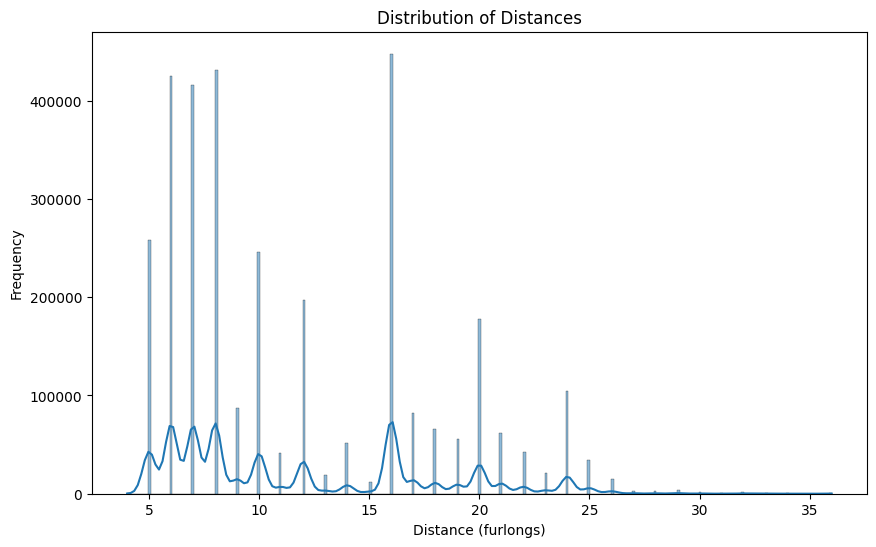

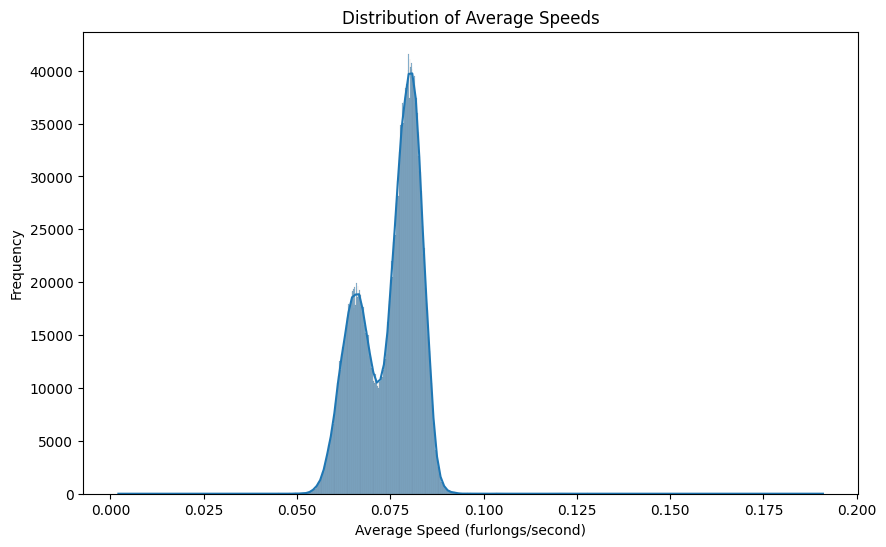

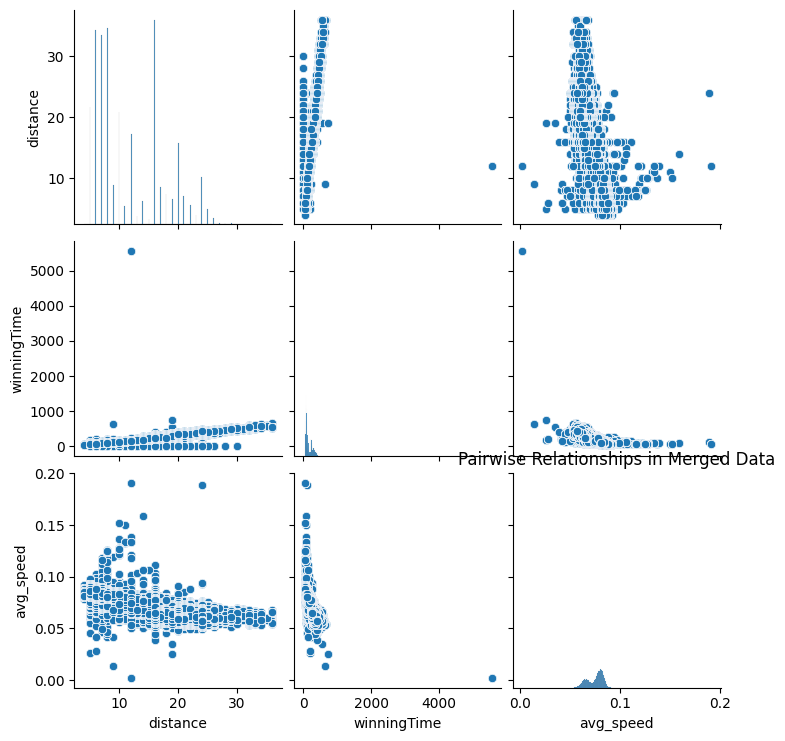

Training and Evaluation:  54%|█████▍    | 7/13 [08:48<09:13, 92.24s/it] 

1284/1284 [==============================] - 2s 2ms/step


Training and Evaluation:  54%|█████▍    | 7/13 [07:44<07:31, 75.23s/it] 

1284/1284 [==============================] - 2s 2ms/step


Training and Evaluation:  54%|█████▍    | 7/13 [09:19<09:14, 92.34s/it] 

1284/1284 [==============================] - 3s 3ms/step


Training and Evaluation:  54%|█████▍    | 7/13 [08:14<08:07, 81.29s/it] 

1284/1284 [==============================] - 3s 2ms/step


Training and Evaluation:  54%|█████▍    | 7/13 [08:58<09:18, 93.04s/it] 

1284/1284 [==============================] - 3s 2ms/step


Training and Evaluation: 100%|██████████| 13/13 [22:51<00:00, 105.49s/it]


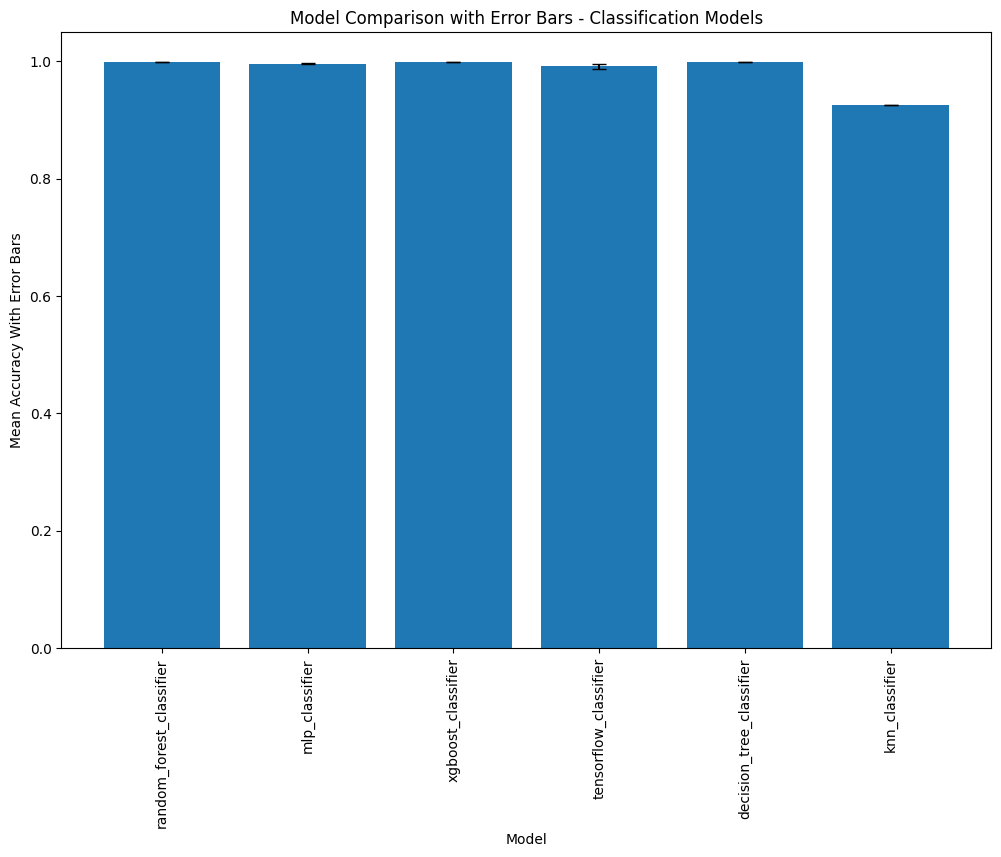

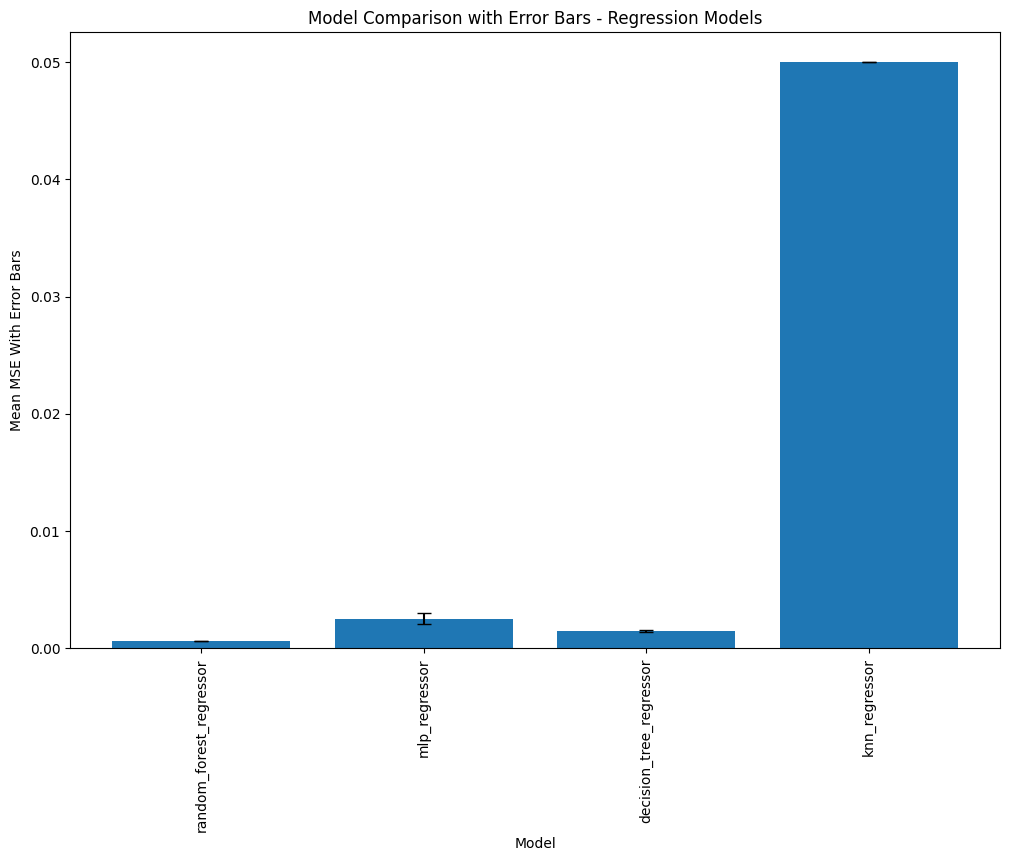

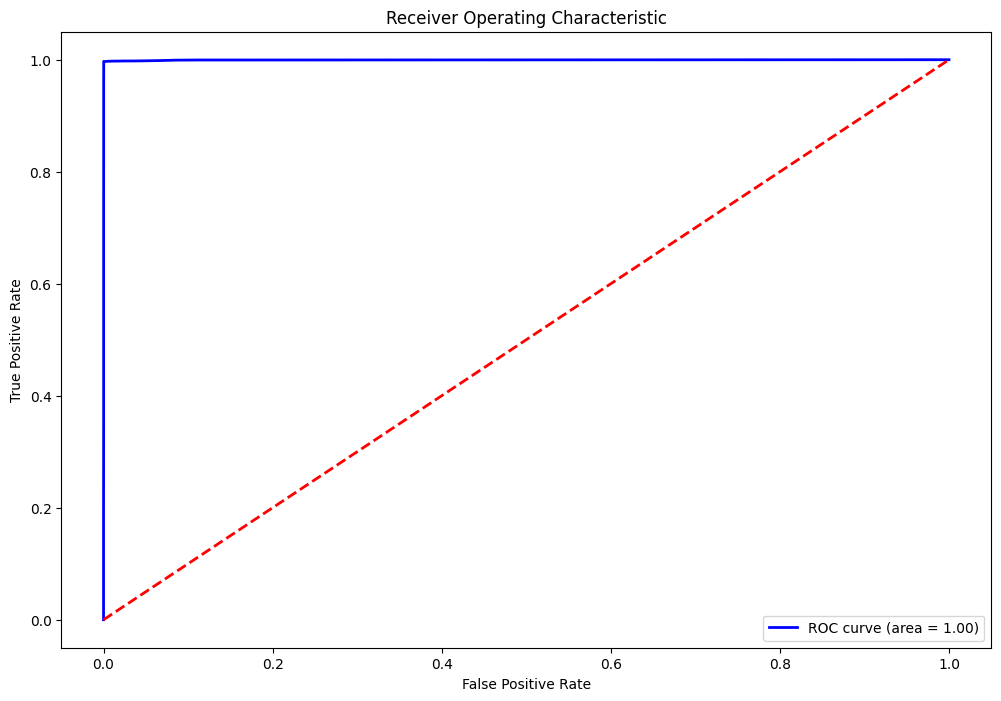

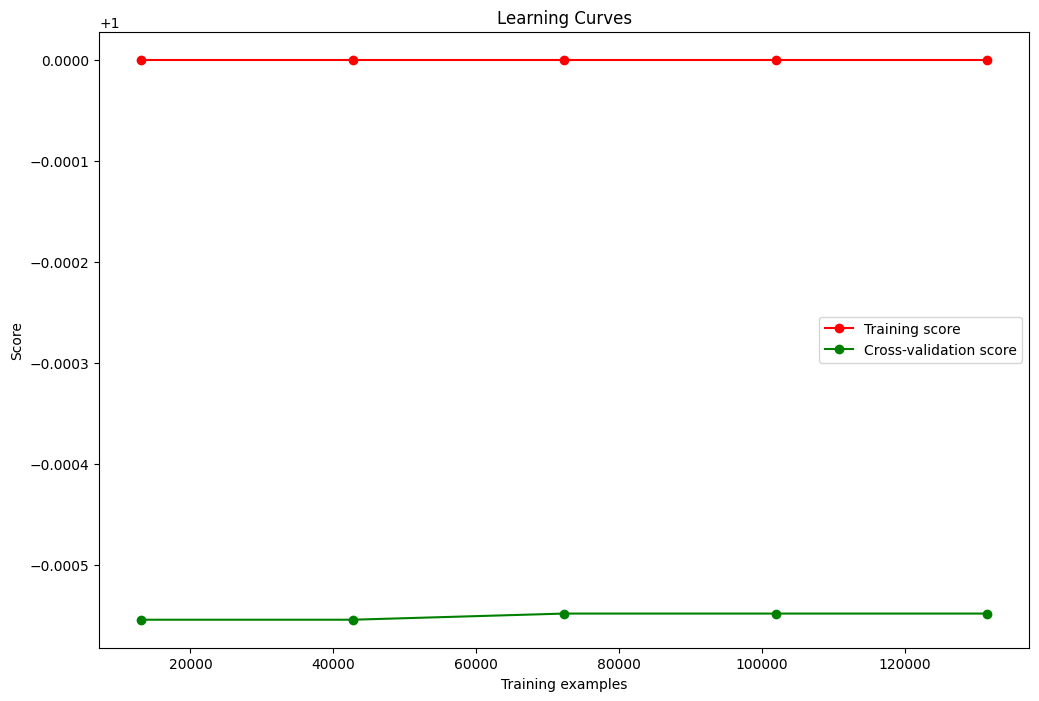

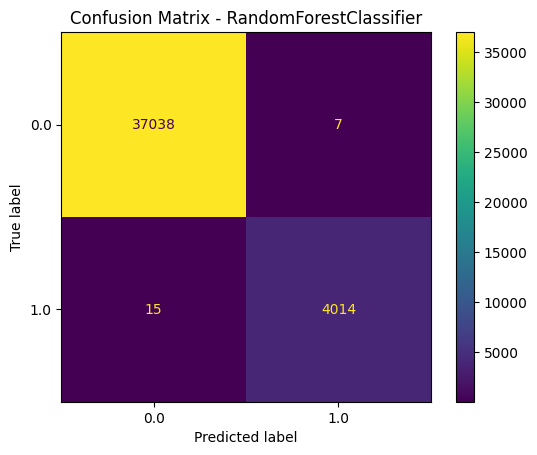

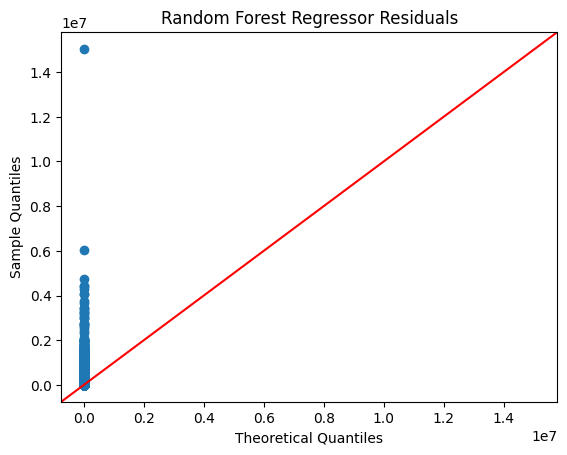

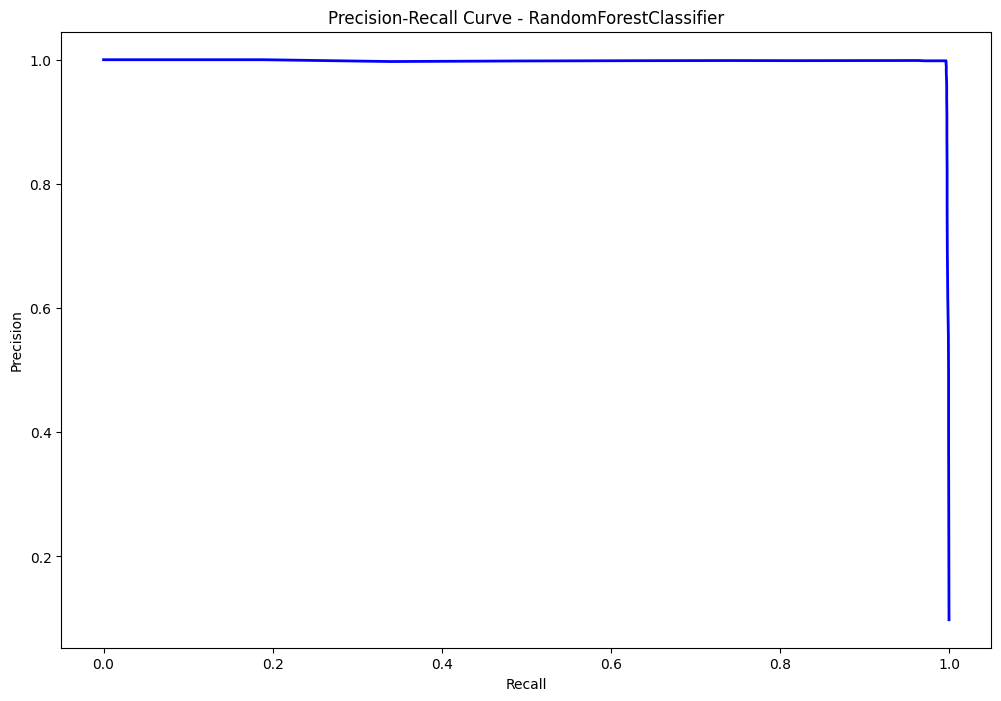

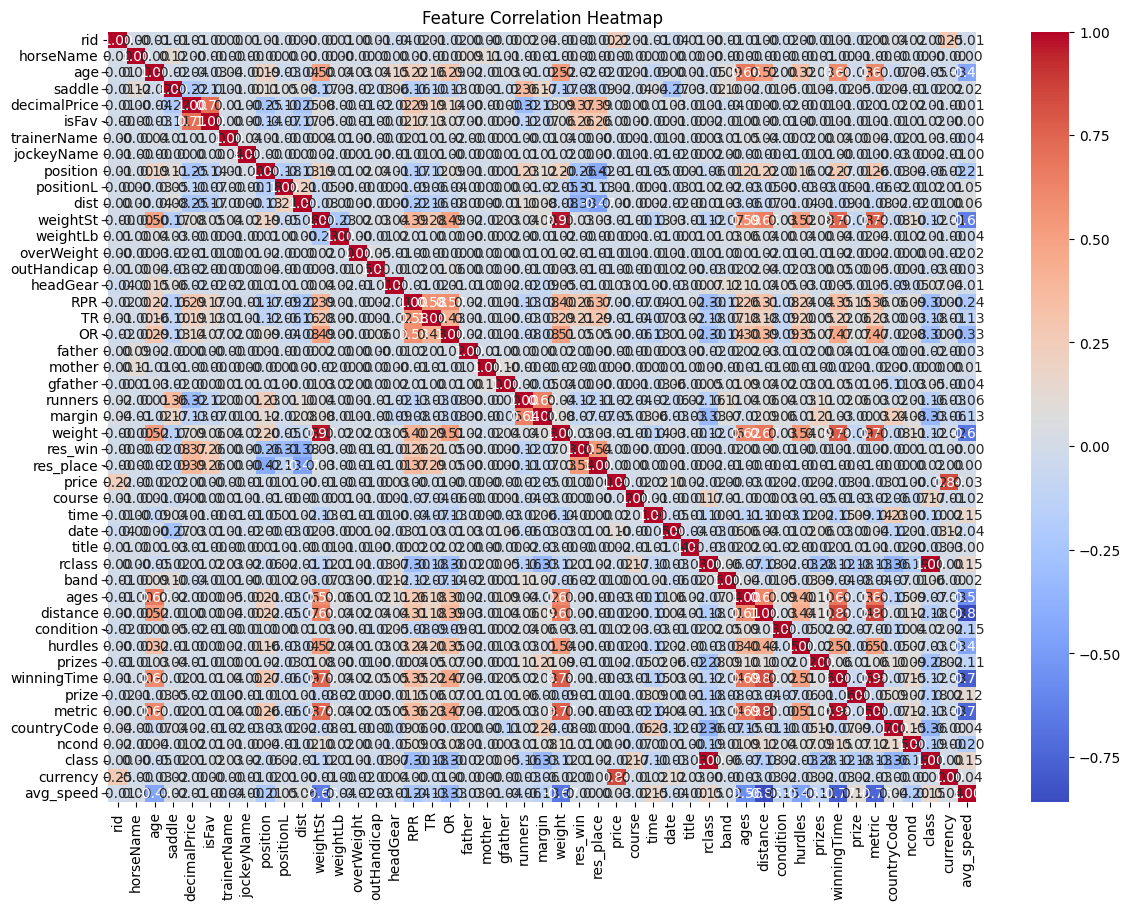

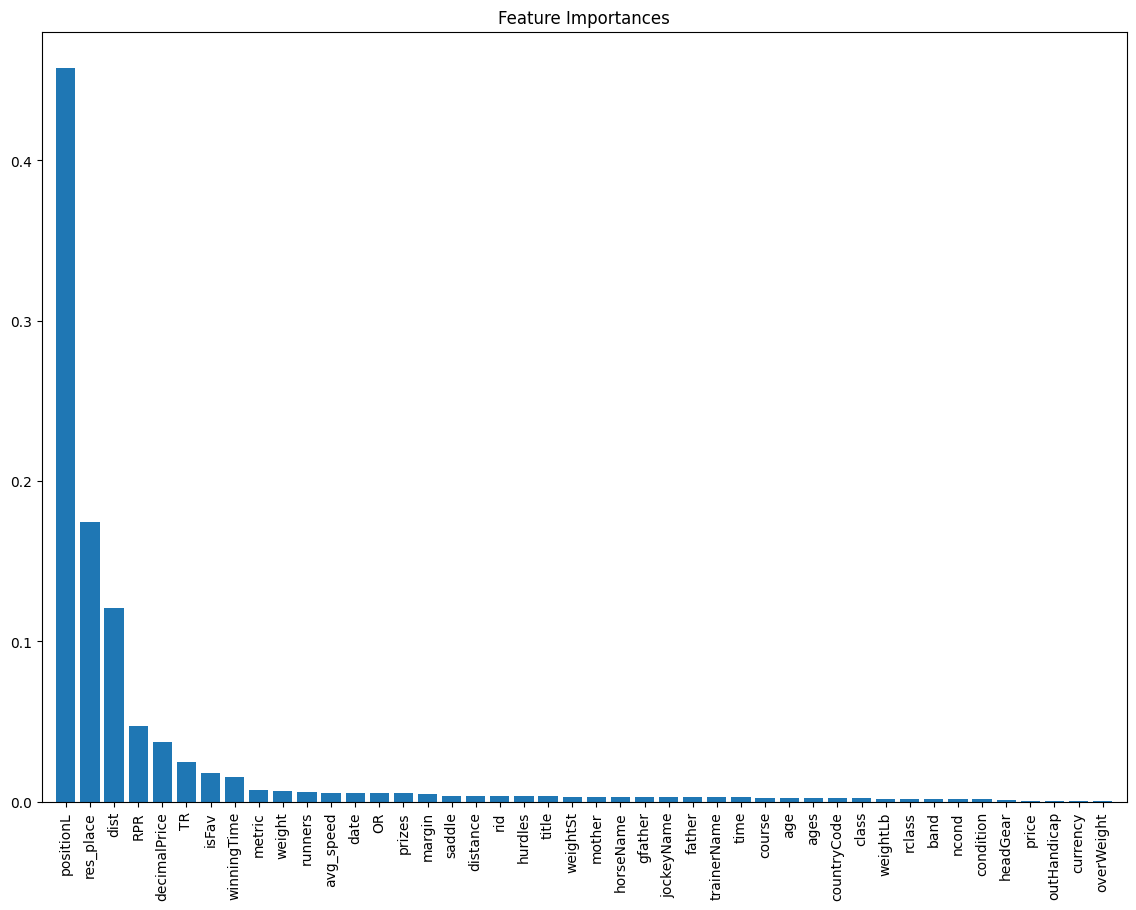

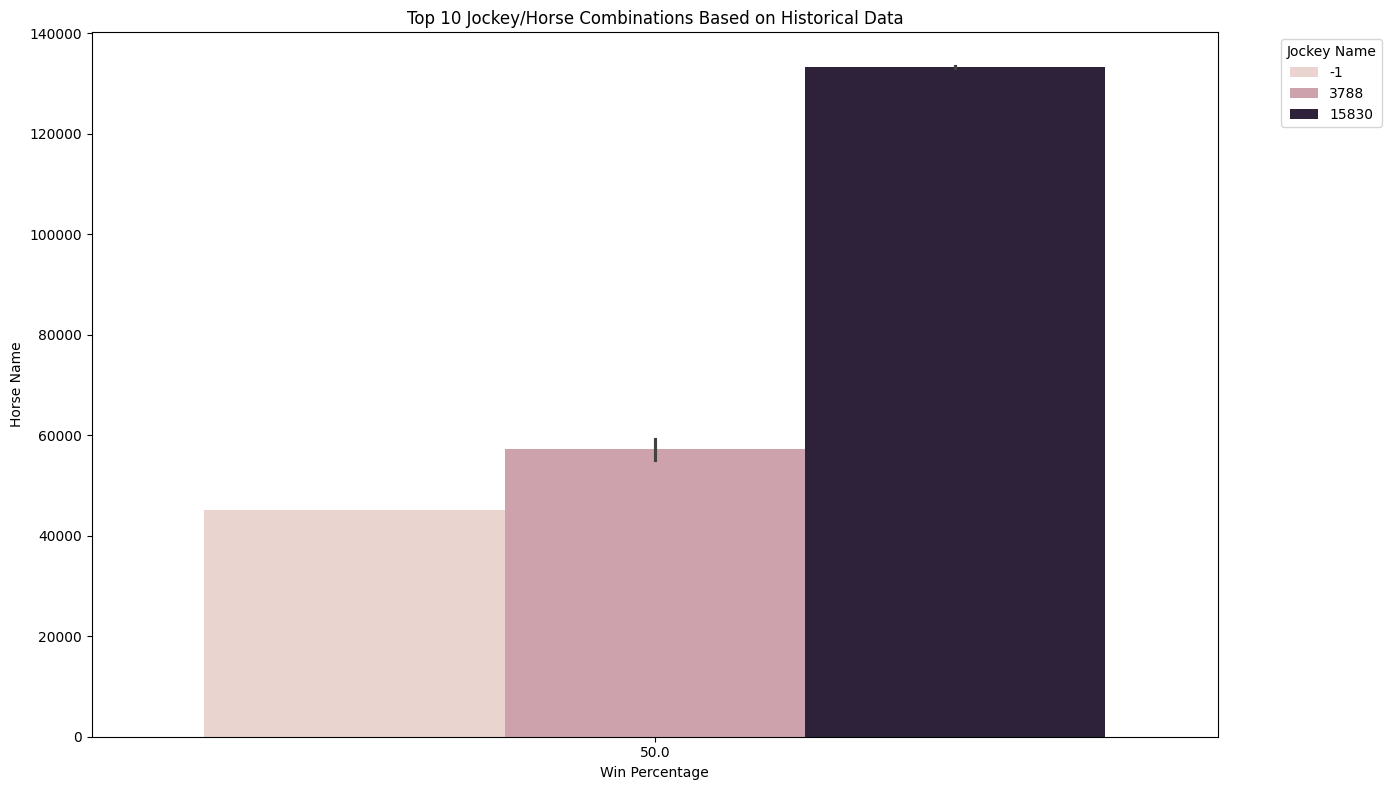

In [ ]:
import os
import psutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from tqdm import tqdm
import numpy as np
import logging
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import shap
import time

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Fix np.bool deprecation issue
np.bool = bool  # Add this line to handle the deprecation

# Set TensorFlow to use a single thread
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Function to log memory usage
def log_memory_usage(stage):
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    logging.info(f"[{stage}] Memory Usage: {memory_info.rss / 1e6} MB")

def plot_distribution(data, column, title, xlabel):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

def plot_pairwise_relationship(data, title, hue=None):
    sns.pairplot(data, hue=hue)
    plt.title(title)
    plt.show()

# Step 1: Ensure the dataset is downloaded and extracted
if not os.path.exists('horse_racing_data'):
    # Download the dataset from Kaggle
    os.system('kaggle datasets download -d hwaitt/horse-racing')
    # Unzip the dataset
    os.system('unzip horse-racing.zip -d horse_racing_data')

# Step 2: Verify extraction by listing files in the directory
logging.info("Listing files in 'horse_racing_data' directory:")
logging.info(os.listdir('horse_racing_data'))

# Step 3: List of all horse and race CSV files
horse_files = [os.path.join('horse_racing_data', file) for file in os.listdir('horse_racing_data') if file.startswith('horses_') and file.endswith('.csv')]
race_files = [os.path.join('horse_racing_data', file) for file in os.listdir('horse_racing_data') if file.startswith('races_') and file.endswith('.csv')]

logging.info("Horse files: %s", horse_files)
logging.info("Race files: %s", race_files)

# Step 4: Specify dtypes to avoid mismatches
dtype_spec_horses = {
    'dist': 'object',
    'ncond': 'object',
    'rclass': 'object',
    'price': 'object',
    'currency': 'object',
    'prize': 'float64',
    'hurdles': 'object',
    'positionL': 'object',
    'headGear': 'object',
    'title': 'object',
    'time': 'object',
    'gfather': 'object'
}
dtype_spec_races = {
    'dist': 'object',
    'ncond': 'object',
    'rclass': 'object',
    'price': 'object',
    'currency': 'object',
    'prize': 'float64',
    'hurdles': 'object',
    'positionL': 'object',
    'headGear': 'object',
    'date': 'object',
    'time': 'object',
    'band': 'object'
}

# Step 5: Load and Process data
start_time = time.time()
def load_data_chunked(files, dtype_spec):
    data_list = []
    for file in tqdm(files, desc='Loading Files'):
        chunk = pd.read_csv(file, dtype=dtype_spec)
        data_list.append(chunk)
    return pd.concat(data_list)

logging.info("Loading horse data in chunks...")
horse_data = load_data_chunked(horse_files, dtype_spec_horses)
log_memory_usage("Horse Data Loaded")

logging.info("Loading race data in chunks...")
race_data = load_data_chunked(race_files, dtype_spec_races)
log_memory_usage("Race Data Loaded")

logging.info(f"Data loading completed in {time.time() - start_time:.2f} seconds")

# Step 6: Check and correct column names
logging.info("Horse Data Columns: %s", horse_data.columns)
logging.info("Race Data Columns: %s", race_data.columns)

# Ensure 'date' column exists and is of string type in race_data
race_data['date'] = race_data['date'].astype(str)

# Step 7: Data Preprocessing: Remove duplicate columns and indexes
start_time = time.time()
def remove_duplicates(data):
    data = data.loc[:, ~data.columns.duplicated()]
    data = data.reset_index(drop=True)
    return data

horse_data = remove_duplicates(horse_data)
race_data = remove_duplicates(race_data)

logging.info(f"Duplicate removal completed in {time.time() - start_time:.2f} seconds")

# Step 8: Validate data
logging.info(horse_data.info())
logging.info(race_data.info())

# Ensure `rid` columns are of integer type and handle missing values
horse_data['rid'] = horse_data['rid'].astype(int)
race_data['rid'] = race_data['rid'].astype(int)

# Debugging: Print unique `rid` values and a sample from both datasets
logging.info("Sample `rid` values from horse data: %s", horse_data['rid'].unique()[:10])
logging.info("Sample `rid` values from race data: %s", race_data['rid'].unique()[:10])

logging.info("Sample records from horse data:")
logging.info(horse_data.head())

logging.info("Sample records from race data:")
logging.info(race_data.head())

# Step 9: Filter common `rid` values
start_time = time.time()
common_rids = horse_data['rid'].isin(race_data['rid'])
logging.info(f"Common `rid` values count: {common_rids.sum()}")

# Filter horse data to include only common rids
horse_data_common = horse_data[horse_data['rid'].isin(race_data['rid'])]

# Check if horse_data_common is empty
if horse_data_common.empty:
    logging.error("No common `rid` values found between horse data and race data.")
    exit()

logging.info(f"Filtering common `rid` values completed in {time.time() - start_time:.2f} seconds")

# Step 10: Efficient merging with pandas
start_time = time.time()
horse_data_common = horse_data_common.set_index('rid').sort_index()
race_data = race_data.set_index('rid').sort_index()

# Handle missing values
merged_data = horse_data_common.merge(race_data, left_index=True, right_index=True).reset_index()
log_memory_usage("Data Merged")

logging.info(f"Data merging completed in {time.time() - start_time:.2f} seconds")

# Step 11: Feature engineering
start_time = time.time()
def convert_distance(dist):
    try:
        parts = dist.lower().replace('m', ' ').replace('f', '').split()
        if len(parts) == 2:
            miles, furlongs = map(float, parts)
        elif len(parts) == 1:
            if 'm' in dist:
                miles = float(parts[0])
                furlongs = 0
            else:
                miles = 0
                furlongs = float(parts[0])
        else:
            return float('nan')
        return miles * 8 + furlongs  # 1 mile = 8 furlongs
    except:
        return float('nan')

# Convert 'distance' column
merged_data['distance'] = merged_data['distance'].apply(convert_distance)
log_memory_usage("Distance Converted")

# Create average speed feature
merged_data['avg_speed'] = merged_data['distance'] / merged_data['winningTime']
log_memory_usage("Average Speed Calculated")

# Visualize distributions
plot_distribution(merged_data, 'distance', 'Distribution of Distances', 'Distance (furlongs)')
plot_distribution(merged_data, 'avg_speed', 'Distribution of Average Speeds', 'Average Speed (furlongs/second)')

logging.info(f"Feature engineering completed in {time.time() - start_time:.2f} seconds")

# Handle duplicate columns
def make_unique(columns):
    seen = set()
    result = []
    for col in columns:
        count = 1
        new_col = col
        while new_col in seen:
            new_col = f"{col}_{count}"
            count += 1
        seen.add(new_col)
        result.append(new_col)
    return result

merged_data.columns = make_unique(list(merged_data.columns))

# Ensure no duplicate column labels before plotting pairwise relationships
plot_pairwise_relationship(merged_data[['distance', 'winningTime', 'avg_speed']], 'Pairwise Relationships in Merged Data')

# Encode categorical variables
categorical_columns = merged_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    merged_data[col] = merged_data[col].astype('category').cat.codes

# Handle missing values
numeric_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns
non_numeric_columns = merged_data.select_dtypes(exclude=['float64', 'int64']).columns

# Fill missing values
merged_data[numeric_columns] = merged_data[numeric_columns].fillna(merged_data[numeric_columns].mean())
for column in non_numeric_columns:
    if not merged_data[column].mode().empty:
        merged_data[column] = merged_data[column].fillna(merged_data[column].mode().iloc[0])
    else:
        merged_data[column] = merged_data[column].fillna('Unknown')

# Replace infinite values with NaN and fill them with the column mean
merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_data.fillna(merged_data.mean(), inplace=True)
log_memory_usage("Missing Values Handled")

# Define target variables
targets = {
    'win_prob': 'res_win',
    'finish_position': 'position',
    'prize_money': 'prize'
}

# Prepare features and targets
X = merged_data.drop(columns=['res_win', 'position', 'prize'])
y_win_prob = merged_data['res_win']
y_finish_position = merged_data['position']
y_prize_money = merged_data['prize']

# Debugging: Check the shape of X and target variables
logging.info(f"Shape of X: {X.shape}")
logging.info(f"Shape of y_win_prob: {y_win_prob.shape}")
logging.info(f"Shape of y_finish_position: {y_finish_position.shape}")
logging.info(f"Shape of y_prize_money: {y_prize_money.shape}")

# Use a subset of data for testing
X_subset = X.sample(frac=0.05, random_state=42)
y_win_prob_subset = y_win_prob.sample(frac=0.05, random_state=42)
y_finish_position_subset = y_finish_position.sample(frac=0.05, random_state=42)
y_prize_money_subset = y_prize_money.sample(frac=0.05, random_state=42)

# Check shapes of data
logging.info(f"Shape of X_subset: {X_subset.shape}")
logging.info(f"Shape of y_win_prob_subset: {y_win_prob_subset.shape}")
logging.info(f"Shape of y_finish_position_subset: {y_finish_position_subset.shape}")
logging.info(f"Shape of y_prize_money_subset: {y_prize_money_subset.shape}")

if X_subset.shape[0] == 0 or y_win_prob_subset.shape[0] == 0:
    logging.error("No samples available for training and testing.")
    exit()

# Split data into training and testing sets
X_train, X_test, y_win_prob_train, y_win_prob_test = train_test_split(X_subset, y_win_prob_subset, test_size=0.2, random_state=42)
_, _, y_finish_position_train, y_finish_position_test = train_test_split(X_subset, y_finish_position_subset, test_size=0.2, random_state=42)
_, _, y_prize_money_train, y_prize_money_test = train_test_split(X_subset, y_prize_money_subset, test_size=0.2, random_state=42)

# Standardize the data
start_time = time.time()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
log_memory_usage("Data Standardized")

logging.info(f"Data standardization completed in {time.time() - start_time:.2f} seconds")

# Initialize and train models
models = {
    'linear_regression': LinearRegression(),
    'logistic_regression': LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=1),  # Increased max_iter for logistic regression
    'random_forest_regressor': RandomForestRegressor(n_jobs=1),
    'random_forest_classifier': RandomForestClassifier(n_jobs=1),
    'mlp_regressor': MLPRegressor(max_iter=200, learning_rate_init=0.001),  # Increased max_iter and adjusted learning_rate_init for MLP
    'mlp_classifier': MLPClassifier(max_iter=200, learning_rate_init=0.001),  # Increased max_iter and adjusted learning_rate_init for MLP
    'xgboost_classifier': xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, n_jobs=1),
    'tensorflow_classifier': None,  # Placeholder for TensorFlow model
    'naive_bayes': GaussianNB(),
    'decision_tree_regressor': DecisionTreeRegressor(),
    'decision_tree_classifier': DecisionTreeClassifier(),
    'knn_regressor': KNeighborsRegressor(),
    'knn_classifier': KNeighborsClassifier(),
}

def create_tf_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

tf_model = create_tf_model(X_train_scaled.shape[1])
tf_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
models['tensorflow_classifier'] = tf_model

def train_and_evaluate(model_name, model, X_train_scaled, X_test_scaled, y_train, y_test):
    log_memory_usage(f"Training {model_name}")
    if model_name == 'tensorflow_classifier':
        model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
        y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, model.predict(X_test_scaled))
        log_memory_usage(f"Completed {model_name}")
        return model_name, {'accuracy': accuracy, 'roc_auc': roc_auc}
    elif 'classifier' in model_name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
        log_memory_usage(f"Completed {model_name}")
        return model_name, {'accuracy': accuracy, 'roc_auc': roc_auc}
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        log_memory_usage(f"Completed {model_name}")
        return model_name, {'mse': mse}

def evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test):
    start_time = time.time()
    results = []
    for model_name, model in tqdm(models.items(), desc='Training and Evaluation'):
        logging.info(f"Training {model_name}")
        result = train_and_evaluate(model_name, model, X_train_scaled, X_test_scaled, y_train, y_test)
        results.append(result)
    logging.info(f"Model evaluation completed in {time.time() - start_time:.2f} seconds")
    return results

# Run 5 iterations for each algorithm
all_results = []
for i in range(5):
    logging.info(f"Iteration {i+1} of 5")
    results = evaluate_models(X_train_scaled, X_test_scaled, y_win_prob_train, y_win_prob_test)
    all_results.append(results)

# Calculate means and standard deviations for each model
model_names = list(models.keys())
classification_metrics = ['accuracy', 'roc_auc']
regression_metrics = ['mse']

# Initialize an empty DataFrame
results_df = pd.DataFrame(columns=['model'] + [f'{metric}_mean' for metric in classification_metrics + regression_metrics] + [f'{metric}_std' for metric in classification_metrics + regression_metrics])

for model_name in model_names:
    model_metrics = {metric: [] for metric in classification_metrics + regression_metrics}
    for result in all_results:
        for res in result:
            if res[0] == model_name:
                for metric in model_metrics.keys():
                    if metric in res[1]:
                        model_metrics[metric].append(res[1][metric])

    row = {'model': model_name}
    for metric in model_metrics.keys():
        if model_metrics[metric]:  # Ensure there is data for the metric
            row[f'{metric}_mean'] = np.mean(model_metrics[metric])
            row[f'{metric}_std'] = np.std(model_metrics[metric])
        else:
            row[f'{metric}_mean'] = np.nan
            row[f'{metric}_std'] = np.nan
    results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

# Display results
logging.info("Final Results with Means and Standard Deviations:")
logging.info(results_df)

# Separate model comparison plots for classifiers and regressors
classifiers = results_df[results_df['model'].str.contains('classifier')]
regressors = results_df[results_df['model'].str.contains('regressor')]

# Plot Error Bars for Classification Models
plt.figure(figsize=(12, 8))
plt.bar(classifiers['model'], classifiers['accuracy_mean'], yerr=classifiers['accuracy_std'], capsize=5)
plt.xlabel('Model')
plt.ylabel('Mean Accuracy With Error Bars')
plt.title('Model Comparison with Error Bars - Classification Models')
plt.xticks(rotation=90)
plt.show()

# Plot Error Bars for Regression Models
plt.figure(figsize=(12, 8))
plt.bar(regressors['model'], regressors['mse_mean'], yerr=regressors['mse_std'], capsize=5)
plt.xlabel('Model')
plt.ylabel('Mean MSE With Error Bars')
plt.title('Model Comparison with Error Bars - Regression Models')
plt.xticks(rotation=90)
plt.show()

# Plot ROC curve for RandomForestClassifier
fpr, tpr, _ = roc_curve(y_win_prob_test, models['random_forest_classifier'].predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot learning curve for RandomForestClassifier
train_sizes, train_scores, test_scores = learning_curve(models['random_forest_classifier'], X_train_scaled, y_win_prob_train, cv=5, n_jobs=1)

plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend(loc="best")
plt.show()

# Visualizations with detailed evaluations

# Plot Confusion Matrix for RandomForestClassifier
ConfusionMatrixDisplay.from_estimator(models['random_forest_classifier'], X_test_scaled, y_win_prob_test)
plt.title('Confusion Matrix - RandomForestClassifier')
plt.show()

# Plot Residuals for RandomForestRegressor
import statsmodels.api as sm

def plot_residuals(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    sm.qqplot(residuals, line='45')
    plt.title(title)
    plt.show()

plot_residuals(models['random_forest_regressor'], X_test_scaled, y_prize_money_test, 'Random Forest Regressor Residuals')

# Plot Precision-Recall Curve for RandomForestClassifier
precision, recall, _ = precision_recall_curve(y_win_prob_test, models['random_forest_classifier'].predict_proba(X_test_scaled)[:, 1])

plt.figure(figsize=(12, 8))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - RandomForestClassifier')
plt.show()

# Plot Feature Correlation Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(merged_data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Feature Importance Visualization for RandomForestClassifier
importances = models['random_forest_classifier'].feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(14, 10))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Group and aggregate data for historical performance
logging.info("Grouping and aggregating data...")
grouped_data = merged_data.groupby(['jockeyName', 'horseName']).agg({'res_win': 'sum', 'res_place': 'sum'}).reset_index()

# Calculate win percentage
logging.info("Calculating win percentage...")
grouped_data['win_percentage'] = (grouped_data['res_win'] / (grouped_data['res_win'] + grouped_data['res_place'])) * 100

# Sort and select top combinations
logging.info("Sorting and selecting top combinations...")
top_combinations = grouped_data.sort_values(by='win_percentage', ascending=False).head(10)

if top_combinations.empty:
    logging.error("No top combinations found.")
    exit()

# Log the top combinations
logging.info("Top 10 Jockey/Horse Combinations:")
logging.info(top_combinations)

# Visualization
logging.info("Visualizing the top combinations...")
plt.figure(figsize=(14, 8))
sns.barplot(x='win_percentage', y='horseName', hue='jockeyName', data=top_combinations)
plt.xlabel('Win Percentage')
plt.ylabel('Horse Name')
plt.title('Top 10 Jockey/Horse Combinations Based on Historical Data')
plt.legend(title='Jockey Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save the top combinations to a CSV file
logging.info("Saving the top combinations to a CSV file...")
top_combinations.to_csv('best_jockey_horse_combinations.csv', index=False)
logging.info("Top combinations saved to 'best_jockey_horse_combinations.csv'.")
